In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

In [3]:
x = df.drop('energy', axis=1)
y = df['energy']


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [5]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [10]:
from sklearn.dummy import DummyRegressor

In [11]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [13]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  9713450126619.39
The dummy's mse:  64410910627596.05
Relative error:  0.15080442167289876


In [14]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)


The model's r2:  0.8491950187531038
The dummy's r2:  -3.7105941010917576e-06


In [15]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2162673.0212625866
The dummy's mae:  6853410.39313192
Relative error:  0.3155615813449445


In [16]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")
    
 



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       9713450126619.391    64410910627596.047   0.151     
R2                        0.849                -0.000               -228856.888
MAE                       2162673.021          6853410.393          0.316     
Ratio of mae over mean value of y: 0.128


#### Let's also look at the residuals to see if there are any patterns.


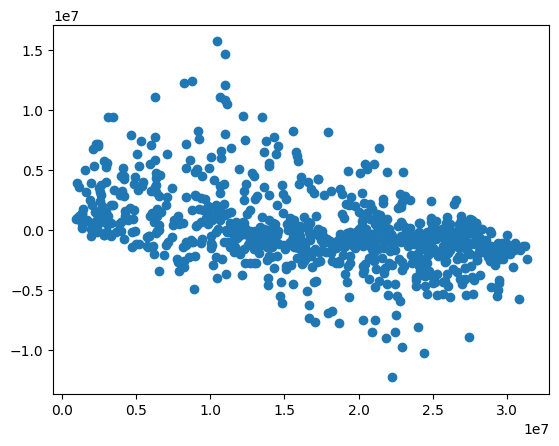

In [17]:
plt.scatter(y_test, y_pred - y_test)
# plt.scatter(y_test, y_pred_dummy - y_test)
plt.show()

# That was the Holdout Method, now do K-Fold Cross Validation

## Pt.2 Hyper parameter tuning with cross validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
# cv = KFold(n_splits=3, shuffle=True, random_state=56)

# Because these take a while to train we are going straight into HPO


# Define the search space for the random forest hyperparameters.

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 4, 6, 8]




param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf    
    
}




rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=56, n_jobs = -1, scoring='neg_mean_absolute_error')


print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')

better_knn.fit(X_train, y_train) 


print(f"{'The best number of neighbors when using negative mean absolute error scoring is: '}", better_knn.best_params_)
print(f"{'The best MAE score attained was: '}", -better_knn.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")
